In [19]:
#import sys
#!{sys.executable} -m pip install pandas
#import sys
#!{sys.executable} -m pip install seaborn


[notice] A new release of pip is available: 24.3.1 -> 26.0.1
[notice] To update, run: pip3 install --upgrade pip


In [35]:
import csv
import numpy as np
import scipy.signal as signal
import matplotlib.pyplot as plt  
from ipywidgets import interact, FloatSlider
from datetime import datetime

import os

import numpy as np
from numpy.linalg import solve

import pandas as pd
from scipy.interpolate import BSpline

import seaborn as sns

from scipy.linalg import lstsq

from scipy.stats import pearsonr


# Traitement de la série temporelle 

In [4]:
# Préparation des dataframes des séries temporelles
Data_file = "data/Data/S1A_ASC-DSC_VV-VH_Paracou"

df_VH_ASC_TropiScat = pd.read_csv(f"{Data_file}/s1a_vh_ASC_047_TropiScat.csv")
df_VH_DSC_TropiScat =  pd.read_csv(f"{Data_file}/s1a_vh_DSC_039_TropiScat.csv")
df_VV_ASC_TropiScat =  pd.read_csv(f"{Data_file}/s1a_vv_ASC_047_TropiScat.csv")
df_VV_DSC_TropiScat =  pd.read_csv(f"{Data_file}/s1a_vv_DSC_039_TropiScat.csv")

dfs_TropiScat = {
    "VV_ASC": df_VV_ASC_TropiScat,
    "VH_ASC": df_VH_ASC_TropiScat,
    "VV_DSC": df_VV_DSC_TropiScat,
    "VH_DSC": df_VH_DSC_TropiScat,
}
df_VH_ASC_allROI =  pd.read_csv(f"{Data_file}/s1a_vh_ASC_047_allROI.csv")
df_VH_DSC_allROI =  pd.read_csv(f"{Data_file}/s1a_vh_DSC_039_allROI.csv")
df_VV_ASC_allROI =  pd.read_csv(f"{Data_file}/s1a_vv_ASC_047_allROI.csv")
df_VV_DSC_allROI =  pd.read_csv(f"{Data_file}/s1a_vv_DSC_039_allROI.csv")

dfs_allROI = {
    "VV_ASC": df_VV_ASC_allROI,
    "VH_ASC": df_VH_ASC_allROI,
    "VV_DSC": df_VV_DSC_allROI,
    "VH_DSC": df_VH_DSC_allROI,
}


value_TropiScat= {
    "VV_ASC": df_VV_ASC_TropiScat.select_dtypes(include='number').to_numpy(),
    "VH_ASC": df_VH_ASC_TropiScat.select_dtypes(include='number').to_numpy(),
    "VV_DSC": df_VV_DSC_TropiScat.select_dtypes(include='number').to_numpy(),
    "VH_DSC": df_VH_DSC_TropiScat.select_dtypes(include='number').to_numpy(),
}

value_allROI = {
    "VV_ASC": df_VV_ASC_allROI.select_dtypes(include='number').to_numpy(),
    "VH_ASC": df_VH_ASC_allROI.select_dtypes(include='number').to_numpy(),
    "VV_DSC": df_VV_DSC_allROI.select_dtypes(include='number').to_numpy(),
    "VH_DSC": df_VH_DSC_allROI.select_dtypes(include='number').to_numpy(),
}

date_TropiScat= {
    "VV_ASC": np.array(df_VV_ASC_TropiScat)[:,0],
    "VH_ASC": np.array(df_VH_ASC_TropiScat)[:,0],
    "VV_DSC": np.array(df_VV_DSC_TropiScat)[:,0],
    "VH_DSC": np.array(df_VH_DSC_TropiScat)[:,0],
}
date_allROI= {
    "VV_ASC": np.array(df_VV_ASC_allROI)[:,0],
    "VH_ASC": np.array(df_VH_ASC_allROI)[:,0],
    "VV_DSC": np.array(df_VV_DSC_allROI)[:,0],
    "VH_DSC": np.array(df_VH_DSC_allROI)[:,0],
}

# Modèle théorique 

Formulation spline :

$$ s(t) = \sum_{j=1}^{K} \beta_j B_j(t) $$

- $B_j(t)$ → fonctions de base B-splines  

- $\beta_j$ → coefficients à estimer  

- $K$ → nombre de fonctions de base (dépend du nombre de nœuds)

Critère pénalisé :

$$ \hat{\beta} = \arg\min_{\beta} \left( \sum (Y - B\beta)^2 + \lambda \sum \beta_j^2 \right) $$


## Implémentation de la base B_Spline

On définit la matrice de base spline :

$$
B =
\begin{bmatrix}
B_1(t_1) & \dots & B_K(t_1) \\
\vdots & \ddots & \vdots \\
B_1(t_n) & \dots & B_K(t_n)
\end{bmatrix}
$$

Chaque ligne correspond à une observation temporelle $t_i$  
Chaque colonne correspond à une fonction de base $B_j(t)$  

In [5]:

def build_bspline_basis(t, n_knots, degree=3):
    knots_internal = np.linspace(t.min(), t.max(), n_knots)
    knots = np.concatenate(([t.min()] * degree,
                            knots_internal,
                            [t.max()] * degree))
    
    K = len(knots) - degree - 1
    B = np.zeros((len(t), K))
    
    for j in range(K):
        coeff = np.zeros(K)
        coeff[j] = 1
        spline_basis = BSpline(knots, coeff, degree)
        B[:, j] = spline_basis(t)
    
    return B

## Regression de la Spline Pénalisée

In [6]:
def penalized_spline_fit(B, Y, lam):
    beta = solve(B.T @ B + lam * np.eye(B.shape[1]), B.T @ Y)
    Y_hat = B @ beta
    return beta, Y_hat

## Matrice de Lissage

$$ S_\lambda = B(B^TB + \lambda I)^{-1}B^T $$

$$ EDF(\lambda) = \mathrm{trace}(S_\lambda) $$


In [7]:
def smoothing_matrix(B, lam):
    return B @ solve(B.T @ B + lam * np.eye(B.shape[1]), B.T)

def compute_edf(B, lam):
    return np.trace(smoothing_matrix(B, lam))

## Optimisation de λ via GCV 

$$ GCV(\lambda) = \frac{n \sum (Y - \hat{s}_\lambda)^2}{(n - EDF(\lambda))^2} $$


In [8]:
def gcv_score(B, Y, lam):
    n = len(Y)
    _, Y_hat = penalized_spline_fit(B, Y, lam)
    residual = np.sum((Y - Y_hat)**2)
    edf = compute_edf(B, lam)
    return (n * residual) / ((n - edf)**2)

def optimize_lambda_gcv(B, Y):
    lambdas = np.logspace(-4, 4, 100)
    scores = np.array([gcv_score(B, Y, lam) for lam in lambdas])
    return lambdas[np.argmin(scores)]

# Modélisation

## Zone régionale

In [9]:
# FONCTION PRINCIPALE MODÉLISATION RÉGIONALE
def regional_penalized_model(t, Y_reg,n, lam=None, auto_lambda=False):
    B = build_bspline_basis(t,n)
    
    if auto_lambda:
        lam = optimize_lambda_gcv(B, Y_reg)
        print("Lambda optimal (GCV) =", lam)
    elif lam is None:
        lam = 1.0
    
    beta, Y_hat = penalized_spline_fit(B, Y_reg, lam)
    EDF = compute_edf(B, lam)
    omega_c = lam**(-1/4)
    
    print("EDF =", EDF)
    print("Fréquence de coupure ω_c =", omega_c)
    
    return Y_hat, lam, EDF, omega_c

## Affichage Splines Superposées

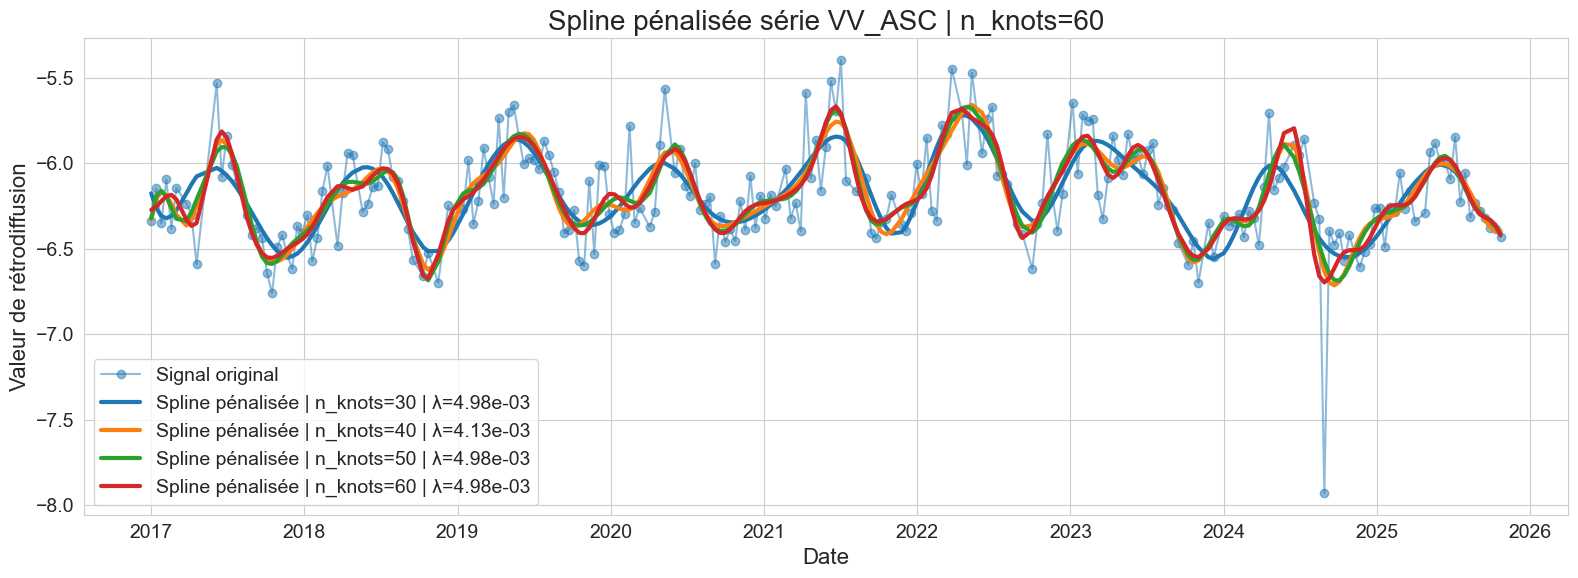

In [ ]:
# --- Paramètres du plot ---
knot_list = [30, 40, 50, 60]  # nombres de noeuds pour les splines
roi_index = 0                 
series_to_plot = "VV_ASC"     # VV_ASC ou VH_ASC 

# Régional/Local sot allROI ou Tropiscat

value_source = value_allROI
date_source  = date_allROI


# Préparer les données pour la série choisie
dates = date_source[series_to_plot]
values_array = value_source[series_to_plot]

# s'assurer que values_array est 2D
if values_array.ndim == 1:
    values_array = values_array[:, np.newaxis]

# ajuster roi_index si nécessaire
roi_idx = min(roi_index, values_array.shape[1]-1)
values = values_array[:, roi_idx]

# temps numérique pour les splines
t = np.arange(len(dates))
fs = 1  # fréquence fictive (optionnel)

# 🎨 Style propre type publication
sns.set_style("whitegrid")
plt.rcParams.update({
    "font.size": 14,
    "axes.titlesize": 20,
    "axes.labelsize": 16,
    "legend.fontsize": 14
})

# Affichage
dates = pd.to_datetime(dates)
t_numeric = np.array([(d - dates[0]).days for d in dates])

plt.figure(figsize=(16, 6))  # figure large et lisible

# 🔵 Signal original (points reliés, semi-transparents)
plt.plot(
    dates,
    values,
    '-o',
    color='tab:blue',
    alpha=0.5,
    linewidth=1.5,
    markersize=6,
    label="Signal original"
)

# 🟠 Superposition des splines
for n_knots in knot_list:
    B = build_bspline_basis(t_numeric, n_knots)
    lam_opt = optimize_lambda_gcv(B, values)
    _, Y_hat = penalized_spline_fit(B, values, lam_opt)
    
    plt.plot(
        dates,
        Y_hat,
        linewidth=3,   # spline bien visible
        label=f"Spline pénalisée | n_knots={n_knots} | λ={lam_opt:.2e}"
    )

# Titres et axes
plt.title(f"Spline pénalisée série {series_to_plot} | n_knots={n_knots}")
plt.xlabel("Date")
plt.ylabel("Valeur de rétrodiffusion")

plt.legend()
plt.tight_layout()
plt.show()

## Affichage Splines Séparées 

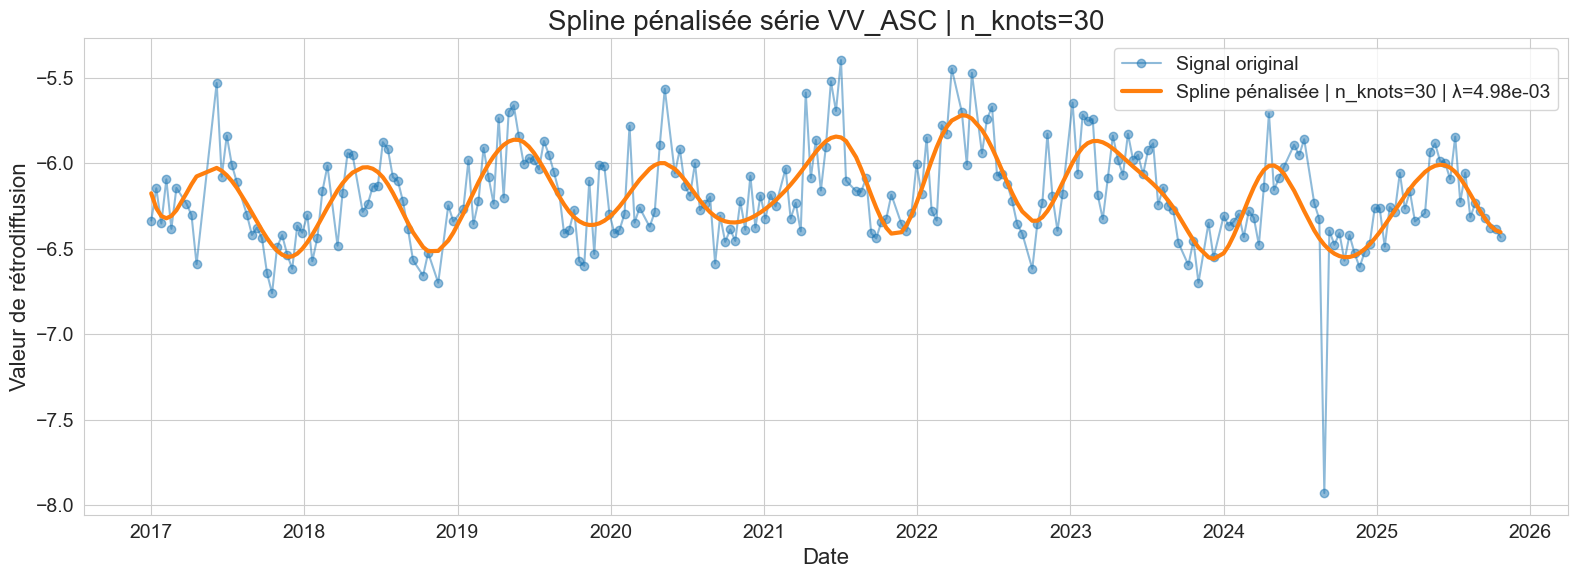

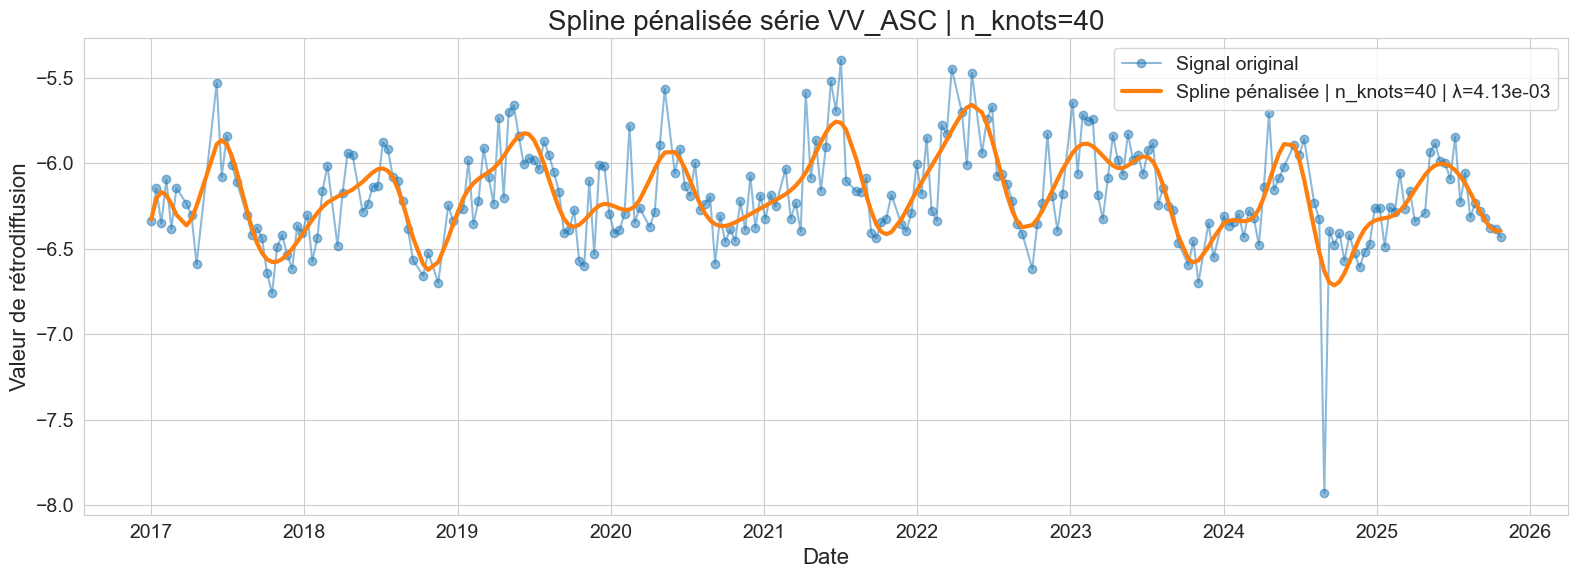

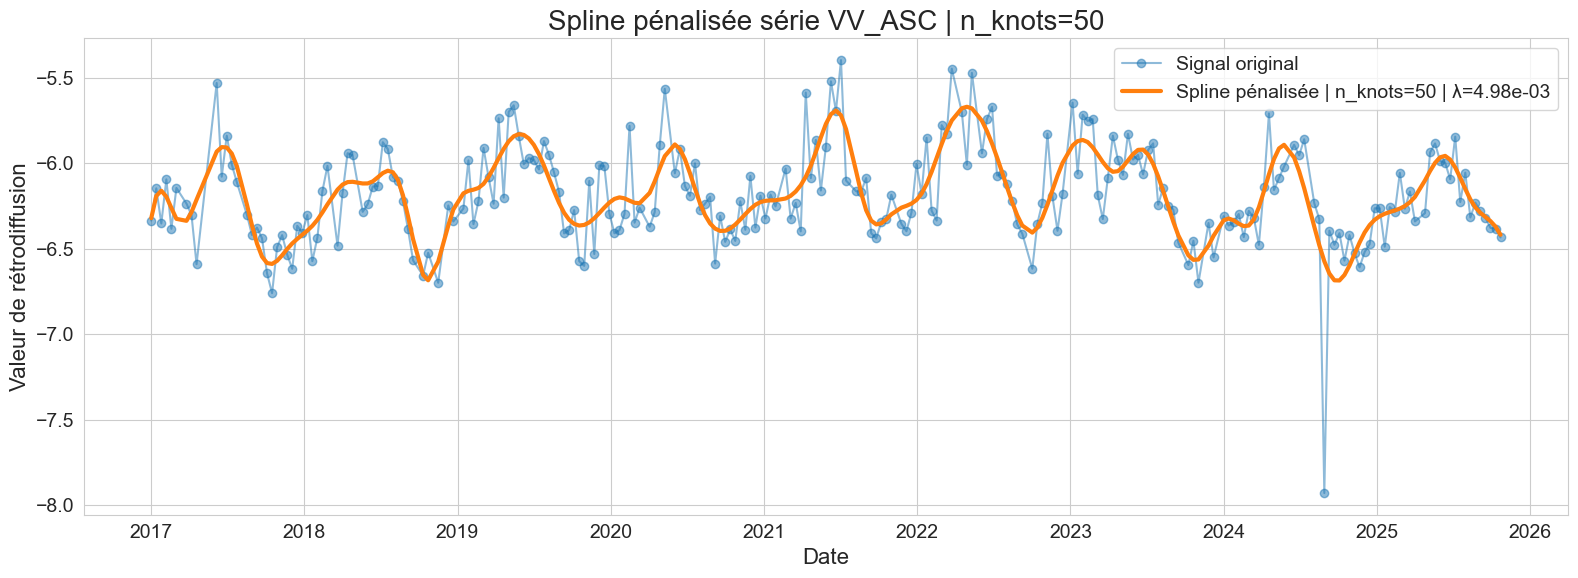

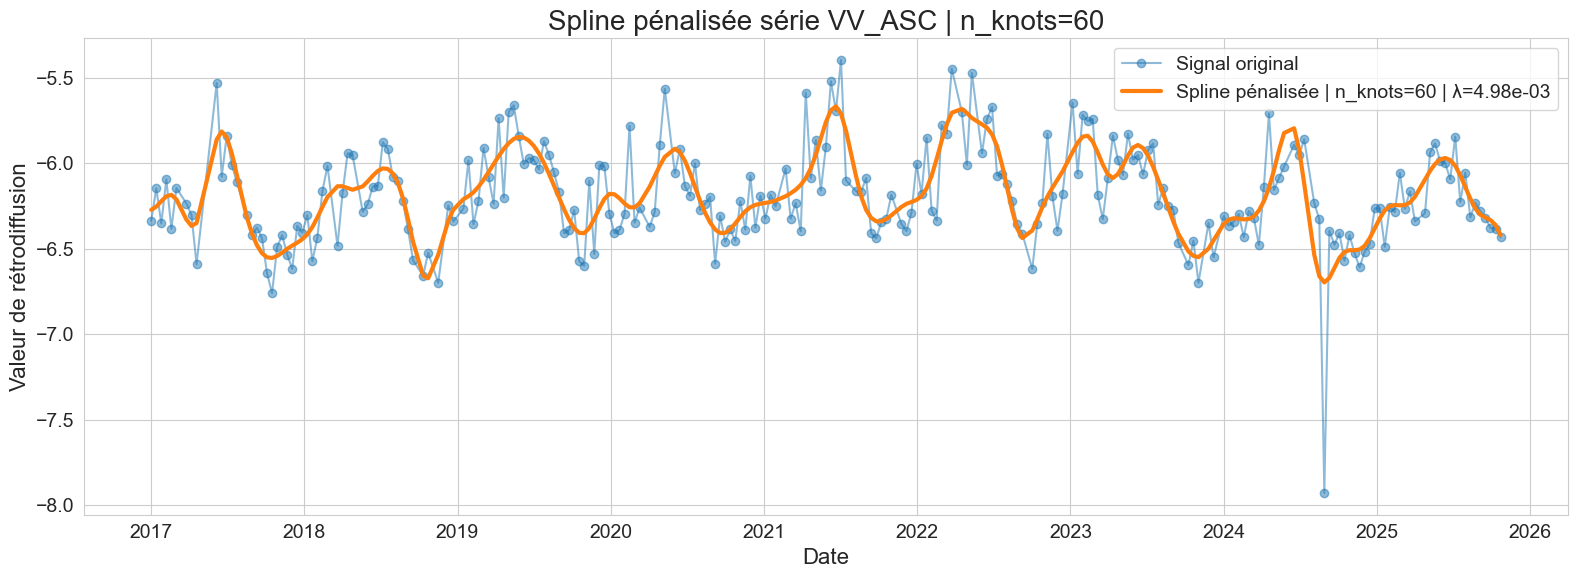

In [ ]:

# Conversion des dates en format numérique pour les splines
dates = pd.to_datetime(dates)
t_numeric = np.array([(d - dates[0]).days for d in dates])

# Boucle sur chaque nombre de nœuds
for n_knots in knot_list:
    plt.figure(figsize=(16, 6))
    
    # Signal original
    plt.plot(
        dates,
        values,
        '-o',
        color='tab:blue',
        alpha=0.5,
        linewidth=1.5,
        markersize=6,
        label="Signal original"
    )
    
    # Spline pénalisée pour ce nombre de nœuds
    B = build_bspline_basis(t_numeric, n_knots)
    lam_opt = optimize_lambda_gcv(B, values)
    _, Y_hat = penalized_spline_fit(B, values, lam_opt)
    
    plt.plot(
        dates,
        Y_hat,
        color='tab:orange',
        linewidth=3,
        label=f"Spline pénalisée | n_knots={n_knots} | λ={lam_opt:.2e}"
    )
    
    # Titres et axes
    plt.title(f"Spline pénalisée série {series_to_plot} | n_knots={n_knots}")
    plt.xlabel("Date")
    plt.ylabel("Valeur de rétrodiffusion")
    
    plt.legend()
    plt.tight_layout()
    plt.show()

# Sélection du nombre de nœuds

## Méthode de suppression pas à pas

Pour ajuster une spline pénalisée aux séries temporelles SAR, il est nécessaire de choisir
le nombre de nœuds $J$ de manière automatique et rigoureuse. On utilise ici la méthode de
**suppression pas à pas** (*stepwise deletion*) décrite par Kooperberg & Stone (1991),
combinée au critère de **Mallows $C_p$ modifié**.

### Principe

On part d'un grand nombre de nœuds initiaux $J_0 = \lfloor T/3 \rfloor$, placés aux
quantiles réguliers du temps. À chaque étape $j$, on supprime un nœud et on évalue la
qualité du modèle résultant via le critère :

$$C_j = \text{RSS}_j + \alpha \cdot (J_0 + 4 - j) \cdot \hat{\sigma}^2$$

où :
- $\text{RSS}_j$ est la somme des carrés des résidus du modèle à l'étape $j$
- $J_0 + 4 - j$ est le nombre de paramètres libres (les $J_0 - j$ nœuds restants + 4 termes polynomiaux de la base cubique)
- $\hat{\sigma}^2 = \text{RSS}_0 / (T - J_0 - 4)$ est la variance résiduelle estimée **une seule fois** sur le modèle complet initial, et fixée pour toutes les étapes
- $\alpha$ est un paramètre de lissage : $\alpha = 3$ est recommandé par Kooperberg & Stone (1991), $\alpha = 2$ correspond à l'AIC, et $\alpha = \log T$ au BIC

Le terme $\alpha \cdot (J_0 + 4 - j) \cdot \hat{\sigma}^2$ joue le rôle d'une **pénalité sur
la complexité** : il augmente avec le nombre de paramètres, ce qui décourage le
sur-ajustement. 
Le modèle retenu $\hat{j}$ est celui qui **minimise $C_j$**, réalisant le
meilleur compromis entre fidélité aux données ($\text{RSS}_j$ faible) et parcimonie
(peu de nœuds).

### Lien avec la spline pénalisée

Une fois le nombre de nœuds $\hat{J}$ sélectionné, la base B-spline cubique est construite
avec $\hat{J}$ nœuds internes, et le paramètre de lissage $\lambda$ est optimisé
automatiquement par **validation croisée généralisée** (GCV) :

$$\text{GCV}(\lambda) = \frac{T \cdot \text{RSS}(\lambda)}{\left(T - \text{EDF}(\lambda)\right)^2}$$

où $\text{EDF}(\lambda) = \text{tr}(\mathbf{H}_\lambda)$ est le nombre de degrés de liberté
effectifs de la spline pénalisée, avec $\mathbf{H}_\lambda = \mathbf{B}(\mathbf{B}^\top\mathbf{B} + \lambda \mathbf{I})^{-1}\mathbf{B}^\top$.

La sélection se fait donc en deux étapes indépendantes :
1. **Nombre de nœuds** $\hat{J}$ → critère de Mallows $C_p$
2. **Intensité de la pénalisation** $\hat{\lambda}$ → critère GCV

Série : VV_ASC  |  ROI index : 0  |  n = 243
Sélection du nombre de nœuds (alpha=3.0) ...

   # nœuds   p=nœuds+4             RSS              Cp
  ------------------------------------------------------
        81          85          6.7102         17.5399  ← modèle initial
        80          84          6.4634         17.1657  ← optimal
        79          83          6.4880         17.0629  ← optimal
        78          82          6.4666         16.9141  ← optimal
        77          81          6.3582         16.6783  ← optimal
        76          80          6.6491         16.8418
        75          79          6.7102         16.7755
        74          78          7.0285         16.9664
        73          77          7.2150         17.0255
        72          76          6.8869         16.5700  ← optimal
        71          75          6.9311         16.4868  ← optimal
        70          74          6.8820         16.3102  ← optimal
        69          73          6.7206    

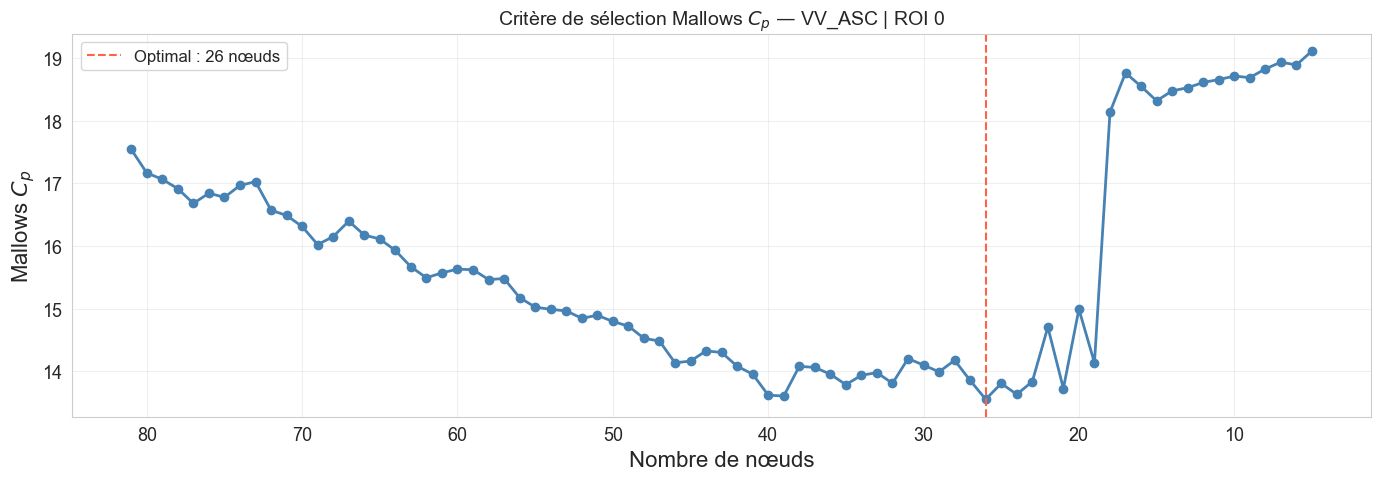

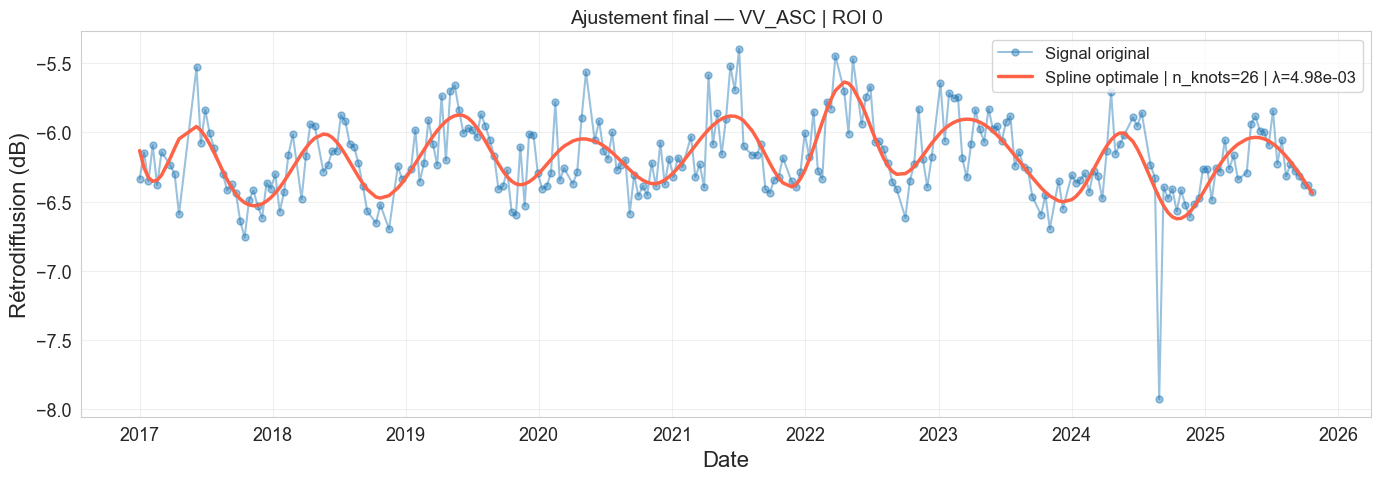

In [34]:
# ════════════════════════════════════════════════════════════
#  PARAMÈTRES — à modifier ici uniquement
# ════════════════════════════════════════════════════════════

series_to_plot = "VV_ASC"        # "VV_ASC" | "VH_ASC" | "VV_DSC" | "VH_DSC"
roi_index      = 0                # index de la ROI
value_source   = value_allROI     # value_allROI ou value_TropiScat
date_source    = date_allROI      # date_allROI  ou date_TropiScat
alpha          = 3.0              # paramètre Mallows Cp (3=Kooperberg, 2=AIC, log(n)=BIC)

# ════════════════════════════════════════════════════════════
#  PRÉPARATION DES DONNÉES
# ════════════════════════════════════════════════════════════

dates = pd.to_datetime(date_source[series_to_plot])
values_array = value_source[series_to_plot]
if values_array.ndim == 1:
    values_array = values_array[:, np.newaxis]
roi_idx = min(roi_index, values_array.shape[1] - 1)
values = values_array[:, roi_idx]

t_numeric = np.array([(d - dates[0]).days for d in dates], dtype=float)

# ════════════════════════════════════════════════════════════
#  SÉLECTION DU NOMBRE DE NŒUDS OPTIMAL (Mallows Cp)
# ════════════════════════════════════════════════════════════

def stepwise_knot_selection_bspline(x, y, alpha=3.0, verbose=True):
    n = len(x)
    min_knots = 5
    n_init = max(min_knots, n // 3)
    quantiles = np.linspace(0, 100, n_init + 2)[1:-1]
    J = len(quantiles)

    B_full = build_bspline_basis(x, J)
    lam_full = optimize_lambda_gcv(B_full, y)
    _, y_hat_full = penalized_spline_fit(B_full, y, lam_full)
    rss_full = np.sum((y - y_hat_full)**2)
    p_full = J + 4
    sigma2_hat = rss_full / max(n - p_full, 1)

    Cp_init = rss_full + alpha * p_full * sigma2_hat
    history = {"Cp": [Cp_init], "RSS": [rss_full], "n_knots": [J]}

    if verbose:
        print(f"  {'# nœuds':>8}  {'p=nœuds+4':>10}  {'RSS':>14}  {'Cp':>14}")
        print("  " + "-" * 54)
        print(f"  {J:>8}  {p_full:>10}  {rss_full:>14.4f}  {Cp_init:>14.4f}  ← modèle initial")

    for step in range(J - 1, min_knots - 1, -1):
        p_j = step + 4
        B   = build_bspline_basis(x, step)
        lam = optimize_lambda_gcv(B, y)
        _, y_hat = penalized_spline_fit(B, y, lam)
        rss = np.sum((y - y_hat)**2)
        Cp  = rss + alpha * p_j * sigma2_hat

        history["Cp"].append(Cp)
        history["RSS"].append(rss)
        history["n_knots"].append(step)

        if verbose:
            marker = "  ← optimal" if Cp == min(history["Cp"]) else ""
            print(f"  {step:>8}  {p_j:>10}  {rss:>14.4f}  {Cp:>14.4f}{marker}")

    best_idx     = np.argmin(history["Cp"])
    best_n_knots = history["n_knots"][best_idx]

    if verbose:
        print(f"\n  ✓ Nœuds optimal : {best_n_knots}  |  Cp = {history['Cp'][best_idx]:.4f}")

    return best_n_knots, history


print(f"Série : {series_to_plot}  |  ROI index : {roi_idx}  |  n = {len(values)}")
print(f"Sélection du nombre de nœuds (alpha={alpha}) ...\n")
n_knots_optimal, history = stepwise_knot_selection_bspline(t_numeric, values, alpha=alpha)

# ════════════════════════════════════════════════════════════
#  AJUSTEMENT FINAL
# ════════════════════════════════════════════════════════════

B        = build_bspline_basis(t_numeric, n_knots_optimal)
lam_opt  = optimize_lambda_gcv(B, values)
_, Y_hat = penalized_spline_fit(B, values, lam_opt)

# ════════════════════════════════════════════════════════════
#  VISUALISATION — graphe 1 : critère Cp
# ════════════════════════════════════════════════════════════

sns.set_style("whitegrid")
plt.rcParams.update({"font.size": 13, "axes.titlesize": 14, "legend.fontsize": 12})

plt.figure(figsize=(14, 5))
plt.plot(history["n_knots"], history["Cp"], "o-", color="steelblue", linewidth=2)
plt.axvline(n_knots_optimal, color="tomato", linestyle="--",
            label=f"Optimal : {n_knots_optimal} nœuds")
plt.xlabel("Nombre de nœuds")
plt.ylabel("Mallows $C_p$")
plt.title(f"Critère de sélection Mallows $C_p$ — {series_to_plot} | ROI {roi_idx}")
plt.gca().invert_xaxis()
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# ════════════════════════════════════════════════════════════
#  VISUALISATION — graphe 2 : ajustement final
# ════════════════════════════════════════════════════════════

plt.figure(figsize=(14, 5))
plt.plot(dates, values, '-o', color='tab:blue', alpha=0.45,
         linewidth=1.5, markersize=5, label="Signal original")
plt.plot(dates, Y_hat, color='tomato', linewidth=2.5,
         label=f"Spline optimale | n_knots={n_knots_optimal} | λ={lam_opt:.2e}")
plt.xlabel("Date")
plt.ylabel("Rétrodiffusion (dB)")
plt.title(f"Ajustement final — {series_to_plot} | ROI {roi_idx}")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Critère de Corrélation Pearson

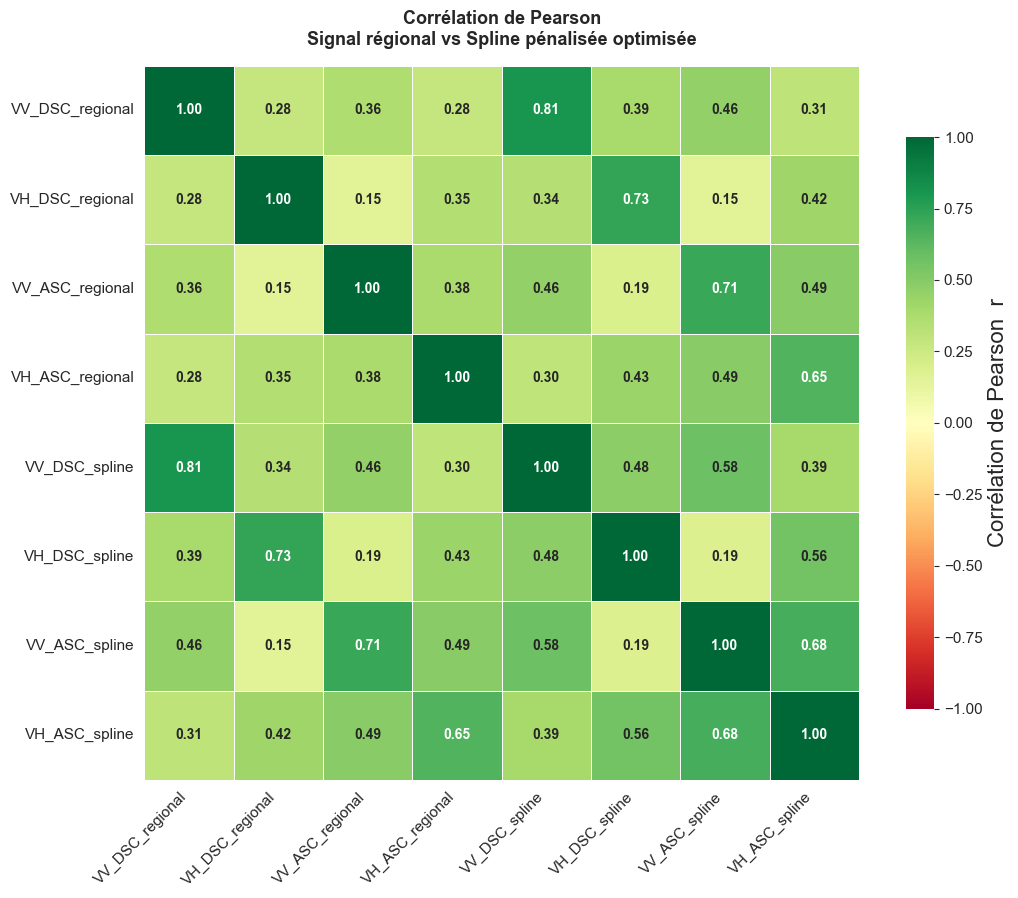

In [40]:
# ════════════════════════════════════════════════════════════
#  PARAMÈTRES
# ════════════════════════════════════════════════════════════

series_list  = ["VV_DSC", "VH_DSC", "VV_ASC", "VH_ASC"]  # même ordre que l'image
roi_index    = 0
alpha        = 3.0

# ════════════════════════════════════════════════════════════
#  CALCUL SIGNAUX ORIGINAUX + SPLINES (régional)
# ════════════════════════════════════════════════════════════

signals = {}
for series in series_list:
    dates        = pd.to_datetime(date_allROI[series])
    values_array = value_allROI[series]
    if values_array.ndim == 1:
        values_array = values_array[:, np.newaxis]
    roi_idx = min(roi_index, values_array.shape[1] - 1)
    values  = values_array[:, roi_idx]
    t_num   = np.array([(d - dates[0]).days for d in dates], dtype=float)

    n_knots_opt, _ = stepwise_knot_selection_bspline(t_num, values, alpha=alpha, verbose=False)
    B               = build_bspline_basis(t_num, n_knots_opt)
    lam_opt         = optimize_lambda_gcv(B, values)
    _, Y_hat        = penalized_spline_fit(B, values, lam_opt)

    signals[f"{series}_regional"] = values
    signals[f"{series}_spline"]   = Y_hat

# Ordonner : d'abord les 4 regionaux, puis les 4 splines (comme l'image)
ordered_keys = [f"{s}_regional" for s in series_list] + \
               [f"{s}_spline"   for s in series_list]

min_len    = min(len(signals[k]) for k in ordered_keys)
df_signals = pd.DataFrame({k: signals[k][:min_len] for k in ordered_keys})

# ════════════════════════════════════════════════════════════
#  MATRICE DE CORRÉLATION
# ════════════════════════════════════════════════════════════

corr_matrix = df_signals.corr(method="pearson")

# ════════════════════════════════════════════════════════════
#  CORRPLOT
# ════════════════════════════════════════════════════════════

sns.set_style("white")
plt.rcParams.update({"font.size": 11})

fig, ax = plt.subplots(figsize=(11, 9))

sns.heatmap(
    corr_matrix,
    ax=ax,
    annot=True,
    fmt=".2f",
    cmap="RdYlGn",
    vmin=-1, vmax=1,
    center=0,
    square=True,
    linewidths=0.5,
    linecolor="white",
    cbar_kws={"label": "Corrélation de Pearson  r", "shrink": 0.8},
    annot_kws={"size": 10, "weight": "bold"}
)

ax.set_title("Corrélation de Pearson\nSignal régional vs Spline pénalisée optimisée",
             fontsize=13, fontweight="bold", pad=15)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)

plt.tight_layout()
plt.show()